In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import Counter
import tensorflow as tf
import scipy.stats
import pandas as pd
from tensorflow.contrib.metrics import streaming_pearson_correlation
from keras.models import load_model
from functools import partial
from sklearn.preprocessing import maxabs_scale, minmax_scale, normalize, scale, robust_scale

/home/nlarusstone/.virtualenvs/nls/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import cobra
%load_ext autoreload
import sys
if not '/home/nlarusstone/cf_fba' in sys.path:
    sys.path.append('/home/nlarusstone/cf_fba')
import src.utils as utils
import src.flux_utils as futils
%autoreload 2

In [56]:
#%%debug
X_train, y_train, X_test, y_test, btol_col, cols = futils.read_data('../data/flux_samps_2k/', resamp=False, scale='flux_zero', n_rows=50000)

2
Min: 0.0, Max: 1.0


In [ ]:
y_vals = futils.scale_data(data=df['AVG.1'].values, scale_type='flux_zero', in_place=False)

In [40]:
from keras.callbacks import Callback
from sklearn.metrics import mean_squared_error as mse
class LossHistory(Callback):
    def __init__(self):
        self.recon_losses = []
        self.kl_losses = []
        
    def on_epoch_end(self, epoch, logs={}):
        y_true = self.validation_data[0]
        y_pred = self.model.predict(self.validation_data[0])
        xent_loss = y_true.shape[-1] * np.mean(np.square(y_true - y_pred), axis=-1)
        inputs = [K.learning_phase()] + self.model.inputs
        zvar = K.function(inputs=inputs, outputs=[self.model.get_layer('z_log_var').output])
        zmn = K.function(inputs=inputs, outputs=[self.model.get_layer('z_mean').output])
        z_log_var = zvar([0, self.validation_data[0]])[0]
        z_mean = zmn([0, self.validation_data[0]])[0]
        kl_loss = - 0.5 * np.sum(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var), axis=-1)
        print "Reconstruction loss: {0}".format(np.mean(xent_loss))
        print "KL loss: {0}".format(np.mean(kl_loss))
        self.recon_losses.append(np.mean(xent_loss))
        self.kl_losses.append(np.mean(kl_loss))

In [120]:
layer_sizes = [1024, 256]

In [57]:
latent_dim = 2
epsilon_std = 1.0

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

def corr_loss(y_true, y_pred):
    cent_pred = y_pred - K.mean(y_pred)
    cent_tr = y_true - K.mean(y_true)

    std_pred = K.std(y_pred)
    std_tr = K.std(y_true)
    return K.mean(cent_pred*cent_tr)/(std_pred*std_tr)

def kl_loss(z_log_var, z_mean):
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

def build_vae(X_shape, n_experiments, targets, output_ind, batch_size=100):
    encoded_dim1 = 1024
    encoded_sz = 256
    # Encoder network
    x = Input(shape=(X_shape,))
    #h = Dense(encoded_dim1, activation='relu')(x)
    h = Dense(encoded_sz, activation='relu')(x)#h)
    z_mean = Dense(latent_dim, name='z_mean')(h)
    z_log_var = Dense(latent_dim, name='z_log_var')(h)
    
    # Sample points from latent space
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    
    # Decoder network
    decoder_h = Dense(encoded_sz, activation='relu')
    #decoder_h2 = Dense(encoded_dim1, activation='relu')
    decoder_mean = Dense(X_shape, activation='tanh')
    h_decoded = decoder_h(z)
    #h_decoded2 = decoder_h2(h_decoded)
    x_decoded_mean = decoder_mean(h_decoded)#2)

    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)
    #vae = Model(x, [x_decoded_mean, x_decoded_mean])
    #output_flux = x_decoded_mean[:, :, output_ind]
    #experiment_loss = scipy.stats.spearmanr(targets, output_flux)
    #experiment_loss_val = -1 * corr_loss(targets, output_flux)#streaming_pearson_correlation(output_flux, targets)
    xent_loss = x.shape[-1].value * metrics.mean_squared_error(x, x_decoded_mean)
    kl_loss_val = kl_loss(z_log_var, z_mean)
    vae_loss = K.mean(xent_loss + kl_loss_val)# + experiment_loss_val
    #print x.shape, x_decoded_mean.shape, z_mean.shape, z_log_var.shape
    #print xent_loss.shape, kl_loss_val.shape, experiment_loss_val.shape, vae_loss.shape
    #vae_loss = K.sum(vae_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    #vae.compile(optimizer='rmsprop', loss=[lambda x, x_pred: gen_vae_loss(x, x_pred, z_log_var, z_mean),
    #                                       lambda x, x_pred: corr_loss(targets, x_pred[:, :, output_ind])])
    vae.summary()

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    #_h_decoded2 = decoder_h2(_h_decoded)
    _x_decoded_mean = decoder_mean(_h_decoded)#2)
    generator = Model(decoder_input, _x_decoded_mean)
    return vae, encoder, generator

In [ ]:
#%%debug
batch_size = 256
X_shape, n_experiments = X_train.shape[1], df.shape[0]
targets = tf.convert_to_tensor(y_vals, dtype=tf.float32)
output_ind = btol_col
vae, encoder, generator = build_vae(X_shape, n_experiments, targets, output_ind, batch_size)
es = EarlyStopping(patience=10)
lh = LossHistory()
#with tf.Session(config=tf.ConfigProto(
#                    intra_op_parallelism_threads=32)) as sess:
#    K.set_session(sess)
hist = vae.fit(X_train,
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_test, None),
        callbacks=[es, lh])
encoder.save('flat_encoder_dim=2_{0}.h5'.format(scale))
generator.save('flat_generator_dim=2_{0}.h5'.format(scale))

/home/nlarusstone/.virtualenvs/nls/lib/python2.7/site-packages/ipykernel_launcher.py:55 UserWarning: Output "dense_39" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_39" during training.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 2639)         0                                            
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 256)          675840      input_25[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         dense_37[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         dense_37[0][0]                   
__________________________________________________________________________________________________
lambda_13 

In [62]:
latent_dim = 10
vae2, encoder2, generator2 = build_vae(X_shape, n_experiments, targets, output_ind, batch_size)
es = EarlyStopping(patience=10)
lh2 = LossHistory()
#with tf.Session(config=tf.ConfigProto(
#                    intra_op_parallelism_threads=32)) as sess:
#    K.set_session(sess)
hist2 = vae2.fit(X_train,
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_test, None),
        callbacks=[es, lh])
encoder2.save('flat_encoder_dim=10_{0}.h5'.format(scale))
generator2.save('flat_generator_dim=10_{0}.h5'.format(scale))

62145/62145 [==============================] - 7s 115us/step - loss: 10.5563 - val_loss: 10.4581
Reconstruction loss: 8.35130768297
KL loss: 2.12197971344
Epoch 7/100
62145/62145 [==============================] - 6s 103us/step - loss: 10.3842 - val_loss: 10.3363
Reconstruction loss: 8.26996534042
KL loss: 2.07983565331
Epoch 8/100
62145/62145 [==============================] - 6s 96us/step - loss: 10.2725 - val_loss: 10.0638
Reconstruction loss: 7.9369064339
KL loss: 2.10778617859
Epoch 9/100
62145/62145 [==============================] - 5s 81us/step - loss: 10.1938 - val_loss: 10.2264
Reconstruction loss: 7.92137890554
KL loss: 2.2857336998
Epoch 10/100
62145/62145 [==============================] - 8s 125us/step - loss: 10.1233 - val_loss: 10.0565
Reconstruction loss: 7.99250593848
KL loss: 2.03997516632
Epoch 11/100
62145/62145 [==============================] - 10s 158us/step - loss: 10.0728 - val_loss: 10.1134
Reconstruction loss: 7.77172402157
KL loss: 2.34678387642
Epoch 12/10

In [111]:
test_enc = encoder2.predict(X_test)
test_dec = generator2.predict(test_enc)

In [71]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [77]:
import matplotlib as mpl

In [ ]:
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

In [94]:
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5,.5,.5,1.0)
cmaplist[1] = (.5,.5,.5,1.0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,40,41)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

19424


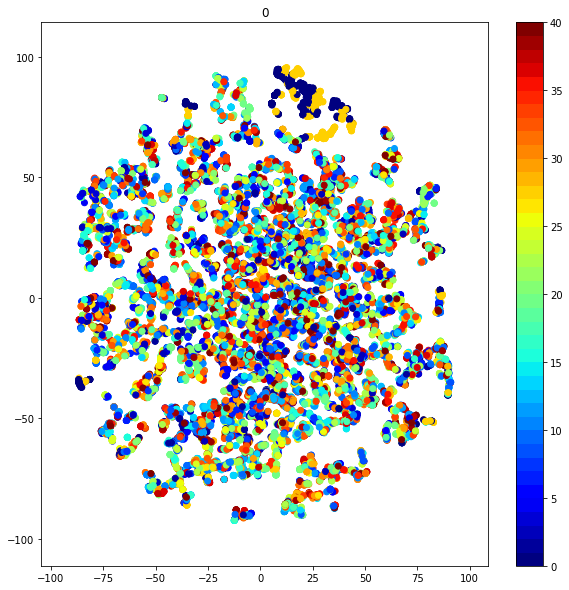

In [117]:
x_test_encoded = X_embedded

def get_rct(df, rct, y_test):
    y_new = []
    for ind in y_test:
        y_new.append(df[rct][ind])
    return y_new

#cmap = cm.get_cmap('plasma', 41)
#cmap = discrete_cmap(41, 'cubehelix')
#for j in range(4):

high_cols = (test_enc[:, 1] > 0)
print sum(high_cols)
xmin, xmax = np.amin(x_test_encoded[:, 0]), np.amax(x_test_encoded[:, 0])
ymin, ymax = np.amin(x_test_encoded[:, 1]), np.amax(x_test_encoded[:, 1])
x_diff = (xmax - xmin) / 10.0
y_diff = (ymax - ymin) / 10.0
#for col in df.columns[4:]:
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=cmap, norm=norm)#get_rct(df, col, y_test), cmap=cmap)
plt.xlim((xmin - x_diff, xmax + x_diff))
plt.ylim((ymin - y_diff, ymax + y_diff))
plt.title(j)
plt.colorbar()
plt.show()

In [118]:
df[df['Glucose'] < 200]

,Area_1,Area_2,Conc_1,Conc_2,AVG,STD,AVG.1,STD.1,Mg(Glu)2,NH4(Glu),K(Glu),Glucose,K2HPO4,NAD,ATP,CoA
0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,8.0,10.0,134,0,10,0.5,0.0,0.5
19,12979.5,8512.2,8.28,5.43,6.86,2.02,0.51,0.15,8.0,10.0,134,120,10,0.5,0.0,0.5
27,14757.7,11211.6,9.42,7.15,8.29,1.60,0.61,0.12,8.0,10.0,134,40,10,0.5,0.0,0.5
29,15992.3,11871.9,10.21,7.58,8.89,1.86,0.66,0.14,8.0,10.0,134,160,10,0.5,0.0,0.5


In [114]:
from sklearn.manifold import TSNE

In [115]:
tsne = TSNE(n_components=2)

In [116]:
X_embedded = tsne.fit_transform(test_enc)